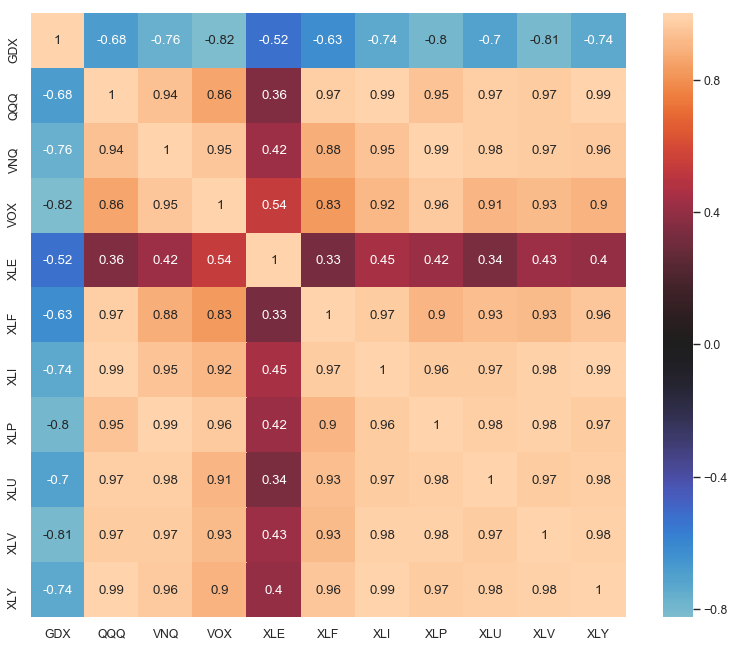

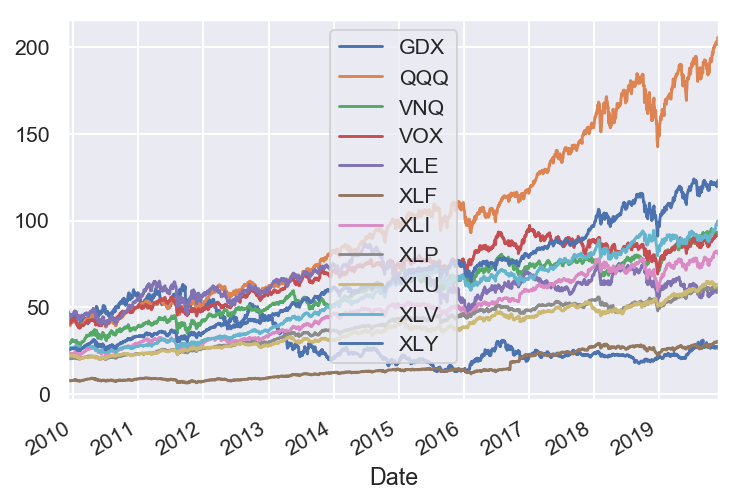

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import qpsolvers as qp
from statistics import mean
from numpy import array, dot
import math

sns.set()

# open the DATA.xlsx file
data = pd.read_excel("DATA.xlsx")

# drop the first column
da = data.drop(data.columns[0], axis=1)

# Correlation Plot
plt.figure(figsize=(12,10), dpi=80)
corr_plot = sns.heatmap(da.corr(), xticklabels=da.corr().columns,
			yticklabels= da.corr(), 
			center=0, annot=True)
plt.show()

# save the correlation plot to the directory
corr_plot.figure.savefig('correlation_plot.png')

# plot the price movements over the past ten years
plt.rcParams["figure.dpi"] = 140
data.plot('Date', list(data.columns[1:]), kind = 'line')

# name of the securities
header = list(data.columns)[1:]

# convert to numpy array
df = data.to_numpy()

# get the dates
date = df[:, 0]

# all prices numpy matrix
prices = df[:, 1:]


In [86]:
# compute the log returns from the price matrix
log_returns = np.diff(np.log(prices.astype('float')), axis=0)


In [87]:
def strategy(log_returns, rolling_window = 11, return_level = None):
    
    """takes in a log return matrix, look-back window, 
        and a return level and returns a sector weight"""
    
    # use the selected part of the return matrix
    selected_period = log_returns[:rolling_window, :]
    
    # compute the average for each ETF over last N days
    r = np.mean(selected_period, axis=0)
    
    # compute the equal weighting expected returns
    naive_average = np.mean(r)
    
    # ensure the user can give his/her own return level
    if return_level == None:
        H = np.negative(np.asarray(naive_average))
    else:
        H = np.negative(np.asarray(return_level))
        
    # the arguments for the QP problem
    R = np.cov(selected_period.T)
    R = R + np.identity(R.shape[0])*(1e-3)
    A = np.ones((11, ))
    Z = np.zeros((11, ))
    B = np.ones((1,))
    g = np.negative(r)
    
    # compute the weights
    weights = qp.solve_qp(P=R, q=Z, G=g, h=H, A=A, b=B)
    return weights.tolist()

strategy(log_returns, rolling_window=11, return_level=None)

[0.01146148568411434,
 0.09752362421916463,
 0.09159471362755188,
 0.11123559197248012,
 0.09667640123832402,
 0.075862605109497,
 0.09336535428403474,
 0.10921492104680382,
 0.1106674362216213,
 0.1063446913666204,
 0.09605317522978775]

Expected Return is:  0.046964665826811657 %
Annualized Return is:  12.560782091883404 %
Cumulative return is:  117.92827589112412 %


Daily vol is:  0.7937324459059649 %
Annual vol is: 12.600111956341264 %
Sharpe Ratio is:  0.9968786099207582


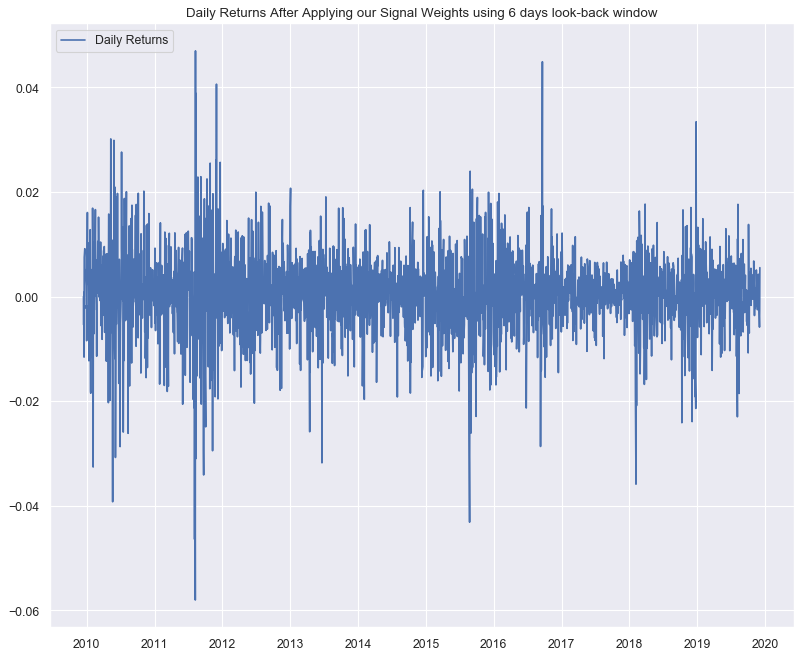

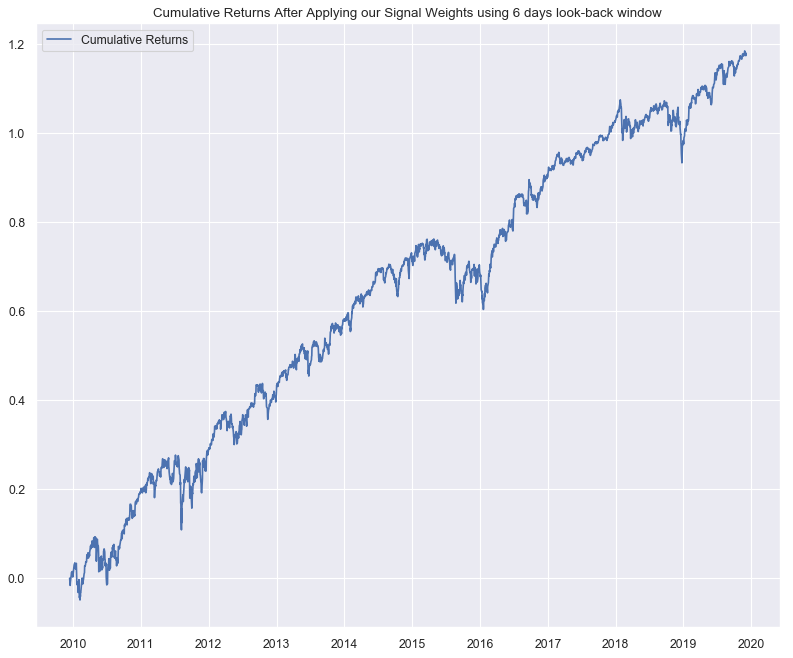

In [88]:
def run_simulation(window_len, returnlevel=None):
    
    """ run the simulation for our strategy given a window 
        length and a return level"""
    
    weights = []
    
    # compute a list of weights
    for i in range(math.floor(log_returns.shape[0] / window_len)):
        weights.append(strategy(log_returns[i * window_len: 
                                            (i + 1) * window_len, :]
                                , window_len, returnlevel))

    # fill the list of weights to align the size with 
    # the shrunk price matrix
    full_weights = np.repeat(weights, window_len, axis=0)

    shrunk_data = prices[window_len:, :]

    while full_weights.shape[0] > shrunk_data.shape[0]:
        full_weights = np.delete(full_weights, -1, 0)
    
    # create return matrix ignoring the first "window length" days
    log_returns_lag1 = np.diff(np.log(shrunk_data.astype('float')), 
                              axis=0)
    log_returns_lag1 = np.vstack((np.zeros((1, 11)), log_returns_lag1))

    # calculate the weighted returns
    weighted_returns = np.multiply(full_weights, log_returns_lag1)

    # get the total returns
    total_returns = np.sum(weighted_returns, axis=1)

    total_returns.tolist()
    
    # plot daily return over the entire period
    plt.figure(0, figsize=(12, 10), dpi=80)
    plt.plot(date.tolist()[window_len:], total_returns)
    plt.legend(('Daily Returns',), loc='upper left')
    plt.title("Daily Returns After Applying our Signal Weights using "
              + str(window_len) + " days look-back window")
    plt.savefig('Daily Returns with ' + str(window_len) 
                                      + ' days look-back window.png')

    # get the summary statistics
    expected_return = np.average(total_returns)
    print("Expected Return is: ", expected_return*100, "%")
    annual_return = (math.pow(expected_return + 1, 252) - 1)
    print("Annualized Return is: ", annual_return*100, "%")

    cumulative_returns = np.cumsum(total_returns)
    print("Cumulative return is: ", cumulative_returns.tolist()[-1]
          *100, "%")

    # plot cumulative returns
    plt.figure(1, figsize=(12, 10), dpi=80)
    plt.plot(date.tolist()[window_len:], cumulative_returns)
    plt.legend(('Cumulative Returns',), loc='upper left')
    plt.title("Cumulative Returns After Applying our Signal Weights using "
              + str(window_len) + " days look-back window")
    plt.savefig('Cumulative Returns with ' + str(window_len) 
                + ' days look-back window.png')
    # calculate performance measures:
    # Information Ratio:
    std = np.std(total_returns)
    print("Daily vol is: ", std*100, "%")
    annual_std = std * math.sqrt(252)
    print("Annual vol is:", annual_std*100, "%")
    Sharpe_Ratio = annual_return / annual_std
    print("Sharpe Ratio is: ", Sharpe_Ratio)

run_simulation(window_len=6)
